# Face Spoofing Detection Challenge
## Intro to Zindi + Mini Hackathon
### In Partnership with IndabaX Zimbabwe: Building Africa's Next Generation of AI Innovators

---

## Welcome to the Starter Notebook!

This notebook provides a complete starter solution for **Face Spoofing Detection** using deep learning. You'll learn how to build an AI system that can distinguish between real faces and fake/spoofed faces (like photos, videos, or masks).

### Learning Objectives

By the end of this notebook, you will:
- Understand what face spoofing is and why it matters
- Learn to work with multi-modal data (color + depth images)
- Build a deep learning model using TensorFlow/Keras
- Evaluate your model's performance
- Identify areas for improvement

### Dataset Overview

This dataset contains pairs of **color** and **depth** images:
- **Training Set**: 2,017 color/depth image pairs with labels (use these to train your model)
- **Validation Set**: 505 color/depth image pairs **with labels** (labels extractable from filenames containing `_real` or `_fake`; use for validation during training)
- **Testing Set**: 620 color/depth image pairs **without labels** (filenames are sequential like `image_01.jpg`; used for leaderboard ranking and final submission)
- **Important**: Test set is for inference only—DO NOT use it for training! Validation set can be used for model validation.

### Getting Started

1. **Run all cells** to see the baseline solution
2. **Experiment** with different models and hyperparameters
3. **Improve** the model performance
4. **Submit** your best predictions!

---

## What is Face Spoofing?

**Face spoofing** (also called face anti-spoofing) is a security challenge where attackers try to fool facial recognition systems using:
- **Printed photos** of authorized users
- **Video replays** on screens
- **3D masks** or silicone faces
- **AI-generated deepfakes**

### Why This Matters

Face spoofing detection is critical for:
- **Mobile device security** (unlocking phones/tablets)
- **Banking & financial services** (secure authentication)
- **Access control systems** (building security)
- **Border control** (passport verification)

### How We Detect Spoofing

We use **depth information** combined with color images because:
- Real faces have natural 3D curvature
- Fake faces (photos, screens, masks) often lack proper depth
- Depth maps reveal flat surfaces vs. natural 3D structures

---

## Dataset Structure

```
face_spoofing_data/
├── train_img/
│   └── train_img/
│       ├── color/          # RGB face images (training data with labels)
│       └── depth/          # Depth map images (training data with labels)
├── test_img/
│   └── test_img/
│       ├── color/          # RGB face images (test data - no labels)
│       └── depth/          # Depth map images (test data - no labels)
└── val_img/
    └── val_img/
        ├── color/          # RGB face images (validation data - labels in filenames)
        └── depth/          # Depth map images (validation data - labels in filenames)
```

### CSV Files

The dataset includes several CSV files:
- **`train.csv`**: Training data with labels (image_id, filename, label: 0=real, 1=fake)
- **`validation.csv`**: Validation data with labels extractable from filenames (image_id, filename) - filenames contain `_real` or `_fake`
- **`test.csv`**: Test data **WITHOUT labels** (image_id, filename) - used for leaderboard ranking and final submission
- **`sample_submission.csv`**: Submission template (image_id, real, fake) - probabilities format matching test.csv

### Dataset Roles

- **Training Set** (`train.csv`): 2,017 labeled samples for model training
- **Validation Set** (`validation.csv`): 505 samples with labels extractable from filenames - use for validation during training (extract labels: `_real` = real, `_fake` = fake)
- **Test Set** (`test.csv`): 620 unlabeled samples for leaderboard ranking and final submission (submit probabilities for real vs. fake)

### Important Notes

- **Validation filenames** mirror the source videos (e.g., `10_1.avi_100_real.jpg`) and contain labels: `_real` = authentic face, `_fake` = spoofed face. You can extract labels from filenames for validation during training.
- **Test filenames** are sequential (`image_01.jpg`, `image_02.jpg`, ..., `image_654.jpg`) and do **not** reveal the ground-truth label. This is used for leaderboard ranking.
- **DO NOT use test data for training** – this will cause data leakage! Validation data can be used for model validation.
- **Submission format**: Submit predictions for **test.csv** only. Predictions must be probabilities (`real`, `fake`) that sum to 1.0 and follow the exact order of `test.csv` (use `sample_submission.csv` as the template).
- **Label encoding**: `_real` in filenames = authentic face (label 0), `_fake` = spoofed face (label 1)


## Section 1: Setup and Imports

Let's start by importing all the necessary libraries and checking our environment setup.


In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("\nAll libraries imported successfully!")


c:\Users\ssikadi.AONZWARSHRE\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\ssikadi.AONZWARSHRE\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\ssikadi.AONZWARSHRE\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime

TensorFlow version: 2.20.0
GPU Available: []

All libraries imported successfully!


## Section 2: Dataset Loading and Exploration

In this section, we'll:
1. Define the dataset paths
2. Load the image paths and labels
3. Visualize sample images
4. Understand the data distribution

### Step 2.1: Define Dataset Paths


In [2]:
# Define dataset paths
# Ensure the 'face_spoofing_data' directory is present in the same location as this notebook.
train_color_path = "face_spoofing_data/train_img/train_img/color"
train_depth_path = "face_spoofing_data/train_img/train_img/depth"
test_color_path = "face_spoofing_data/test_img/test_img/color"
test_depth_path = "face_spoofing_data/test_img/test_img/depth"
val_color_path = "face_spoofing_data/val_img/val_img/color"
val_depth_path = "face_spoofing_data/val_img/val_img/depth"

print("Dataset paths set as follows:")
print(f"   Training (color): {train_color_path}")
print(f"   Training (depth): {train_depth_path}")
print(f"   Test (color): {test_color_path}")
print(f"   Test (depth): {test_depth_path}")
print(f"   Validation (color): {val_color_path}")
print(f"   Validation (depth): {val_depth_path}")

# Step 2.2: Prepare for Image Path and Label Loading

# Images will be loaded and associated with labels inferred from their filenames:
#   - Filenames containing 'real' are assigned label 0 (Real face)
#   - Filenames containing 'fake' are assigned label 1 (Fake/Spoofed face)


Dataset paths set as follows:
   Training (color): face_spoofing_data/train_img/train_img/color
   Training (depth): face_spoofing_data/train_img/train_img/depth
   Test (color): face_spoofing_data/test_img/test_img/color
   Test (depth): face_spoofing_data/test_img/test_img/depth
   Validation (color): face_spoofing_data/val_img/val_img/color
   Validation (depth): face_spoofing_data/val_img/val_img/depth


In [3]:
def get_image_paths_and_labels(data_path):
    """
    Extract image paths and labels from dataset directory.
    
    Args:
        data_path: Path to directory containing images
        
    Returns:
        image_paths: List of full image paths
        labels: List of labels (0=real, 1=fake)
    """
    image_paths = []
    labels = []
    
    if not os.path.exists(data_path):
        print(f"Warning: Path does not exist: {data_path}")
        return image_paths, labels
    
    for filename in sorted(os.listdir(data_path)):
        if filename.endswith('.jpg'):
            image_paths.append(os.path.join(data_path, filename))
            # Extract label from filename (real or fake)
            if 'real' in filename.lower():
                labels.append(0)  # Real = 0
            elif 'fake' in filename.lower():
                labels.append(1)  # Fake = 1
    
    return image_paths, labels

# Get training data
print("Loading training data...")
train_color_paths, train_labels = get_image_paths_and_labels(train_color_path)
train_depth_paths, _ = get_image_paths_and_labels(train_depth_path)

# Get test data
print("Loading test data...")
test_color_paths, test_labels = get_image_paths_and_labels(test_color_path)
test_depth_paths, _ = get_image_paths_and_labels(test_depth_path)

# Display dataset statistics
print("\n" + "="*50)
print("DATASET STATISTICS")
print("="*50)
print(f"Training samples: {len(train_color_paths)}")
print(f"  Real faces: {train_labels.count(0)}")
print(f"  Fake faces: {train_labels.count(1)}")
print(f"\nTest samples: {len(test_color_paths)}")
print(f"  Real faces: {test_labels.count(0)}")
print(f"  Fake faces: {test_labels.count(1)}")
print("="*50)


Loading training data...
Loading test data...

DATASET STATISTICS
Training samples: 2522
  Real faces: 618
  Fake faces: 1904

Test samples: 620
  Real faces: 0
  Fake faces: 0


### Step 2.3: Visualize Sample Images

Let's look at some examples from our dataset to understand what we're working with!


Training Sample Images:
Top row: Color images | Bottom row: Depth maps


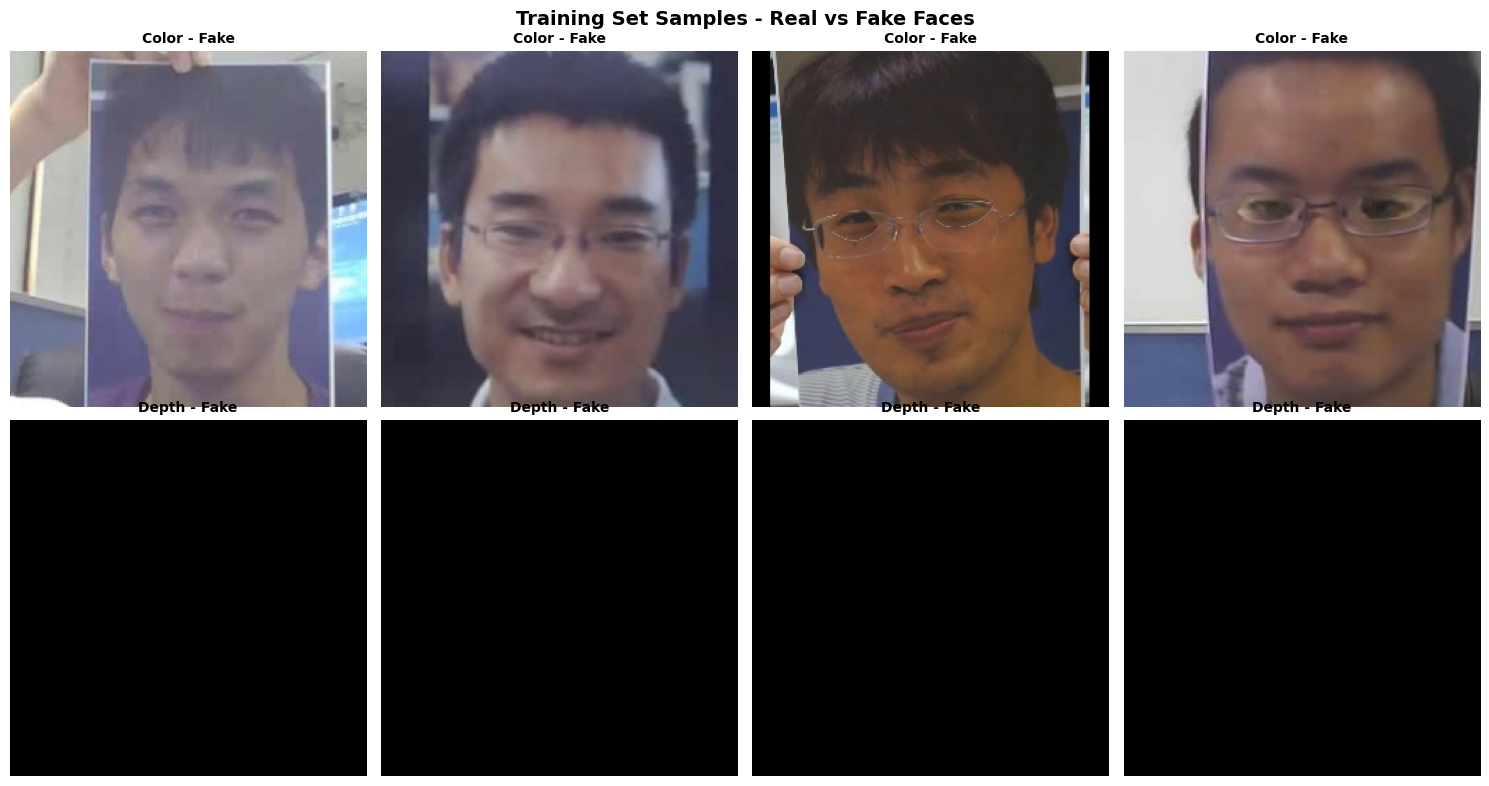

In [4]:
def display_sample_images(color_paths, depth_paths, labels, num_samples=4, title="Sample Images"):
    """
    Display sample color and depth images side by side.
    
    Args:
        color_paths: List of color image paths
        depth_paths: List of depth image paths
        labels: List of labels (0=real, 1=fake)
        num_samples: Number of samples to display
        title: Plot title
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    # Select random samples
    if len(color_paths) < num_samples:
        num_samples = len(color_paths)
    indices = np.random.choice(len(color_paths), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Load and display color image
        color_img = Image.open(color_paths[idx])
        axes[0, i].imshow(color_img)
        label_text = "Real" if labels[idx] == 0 else "Fake"
        axes[0, i].set_title(f'Color - {label_text}', fontsize=10, fontweight='bold')
        axes[0, i].axis('off')
        
        # Load and display depth image
        depth_img = Image.open(depth_paths[idx])
        axes[1, i].imshow(depth_img, cmap='gray')
        axes[1, i].set_title(f'Depth - {label_text}', fontsize=10, fontweight='bold')
        axes[1, i].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Display training samples
print("Training Sample Images:")
print("Top row: Color images | Bottom row: Depth maps")
display_sample_images(train_color_paths, train_depth_paths, train_labels, 
                     title="Training Set Samples - Real vs Fake Faces")


## Section 3: Data Preprocessing

Before training, we need to:
1. Resize images to a consistent size
2. Normalize pixel values
3. Combine color (RGB) and depth channels into a 4-channel input
4. Create TensorFlow datasets for efficient training

### Step 3.1: Image Preprocessing Functions


In [5]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess image for model input.
    
    Args:
        image_path: Path to image file
        target_size: Target size (height, width)
        
    Returns:
        Preprocessed image array (normalized to [0, 1])
    """
    img = Image.open(image_path)
    img = img.convert('RGB')  # Ensure RGB format (3 channels)
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    return img_array

print("Image preprocessing function defined!")


Image preprocessing function defined!


In [6]:
def create_dataset(color_paths, depth_paths, labels, batch_size=32, target_size=(224, 224)):
    """
    Create TensorFlow dataset from image paths and labels.
    
    This function combines color (RGB) and depth images into a 4-channel input.
    
    Args:
        color_paths: List of color image paths
        depth_paths: List of depth image paths
        labels: List of labels
        batch_size: Batch size for training
        target_size: Target image size
        
    Returns:
        Batched and prefetched TensorFlow dataset
    """
    def generator():
        for i in range(len(color_paths)):
            # Load and preprocess color image (RGB - 3 channels)
            color_img = load_and_preprocess_image(color_paths[i], target_size)
            # Load and preprocess depth image (Grayscale - 1 channel)
            depth_img = load_and_preprocess_image(depth_paths[i], target_size)
            # Extract only one channel from depth (it's grayscale anyway)
            depth_channel = depth_img[:, :, :1]  # Shape: (224, 224, 1)
            # Combine color and depth: RGB + D = 4 channels
            combined_img = np.concatenate([color_img, depth_channel], axis=-1)
            yield combined_img, labels[i]
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(*target_size, 4), dtype=tf.float32),  # 4-channel input
            tf.TensorSpec(shape=(), dtype=tf.int32)  # Label
        )
    )
    
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Dataset creation function defined!")
print("   Input shape: (224, 224, 4) - RGB + Depth")
print("   Output: Binary classification (0=Real, 1=Fake)")


Dataset creation function defined!
   Input shape: (224, 224, 4) - RGB + Depth
   Output: Binary classification (0=Real, 1=Fake)


## Section 4: Model Architecture

Now let's build our deep learning model! We'll use a **Convolutional Neural Network (CNN)** that can learn features from the 4-channel input (RGB + Depth).

### Why This Architecture?

- **Convolutional layers**: Extract spatial features from images
- **Pooling layers**: Reduce dimensionality and prevent overfitting
- **Dense layers**: Make the final classification decision
- **Dropout**: Regularization to prevent overfitting

### Step 4.1: Define the Model


In [7]:
def create_improved_spoofing_model(input_shape=(224, 224, 4)):
    """
    Create a simple (but better than trivial) model for face spoofing detection.
    Improvements:
      - Add two convolutional layers to extract spatial features
      - MaxPooling for slight downsampling
      - One slightly larger dense layer and Dropout for regularization
      - Output: single sigmoid neuron for binary classification

    Args:
        input_shape: Shape of input images (height, width, channels)

    Returns:
        Keras model (not compiled)
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='conv1'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool1'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.MaxPooling2D(pool_size=(2, 2), name='pool2'),
        layers.Flatten(name='flatten'),
        layers.Dense(32, activation='relu', name='dense1'),
        layers.Dropout(0.3, name='dropout'),
        layers.Dense(1, activation='sigmoid', name='output')
    ])
    return model

print("Building a simple (but improved) CNN model for spoofing detection...")
model = create_improved_spoofing_model()
print("\nModel Summary:")
model.summary()


Building a simple (but improved) CNN model for spoofing detection...

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 224, 224, 16)   │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 32)             │     3,211,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,216,561 (12.27 MB)

 Trainable params: 3,216,561 (12.27 MB)

 Non-trainable params: 0 (0.00 B)

### Step 4.2: Compile the Model

Now we'll compile the model with appropriate settings for binary classification.


In [8]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Learning rate
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']  # Track accuracy during training
)

print("Model compiled successfully!")
print("\nCompilation Details:")
print("   Loss function: Binary Crossentropy")
print("   Optimizer: Adam (learning_rate=0.001)")
print("   Metrics: Accuracy")
print("\nTip: You can experiment with different learning rates!")


Model compiled successfully!

Compilation Details:
   Loss function: Binary Crossentropy
   Optimizer: Adam (learning_rate=0.001)
   Metrics: Accuracy

Tip: You can experiment with different learning rates!


## Section 5: Train-Validation Split

Before training, we need to split our training data into training and validation sets. This helps us:
- Monitor training progress
- Detect overfitting
- Choose the best model

### Step 5.1: Split Training Data


In [9]:
# Split training data into train and validation sets
train_color_paths_split, val_color_paths_split, train_labels_split, val_labels_split = train_test_split(
    train_color_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Get corresponding depth paths
train_depth_paths_split = [train_depth_paths[i] for i in range(len(train_color_paths)) if train_color_paths[i] in train_color_paths_split]
val_depth_paths_split = [train_depth_paths[i] for i in range(len(train_color_paths)) if train_color_paths[i] in val_color_paths_split]

print(f"Training samples: {len(train_color_paths_split)}")
print(f"Validation samples: {len(val_color_paths_split)}")
print(f"Test samples: {len(test_color_paths)}")

# Create train and validation datasets
train_dataset_split = create_dataset(train_color_paths_split, train_depth_paths_split, train_labels_split)
val_dataset_split = create_dataset(val_color_paths_split, val_depth_paths_split, val_labels_split)

print("Data splitting completed!")


Training samples: 2017
Validation samples: 505
Test samples: 620
Data splitting completed!


### Step 5.2: Setup Training Callbacks

Callbacks help us monitor and improve training:
- **EarlyStopping**: Stop training if validation loss stops improving (prevents overfitting)


In [ ]:
# Define callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',           # Monitor validation loss
        patience=5,                   # Wait 5 epochs without improvement
        restore_best_weights=True,    # Restore best weights when stopping
        verbose=1,                    # Print messages
        min_delta=0.001               # Minimum change to qualify as improvement
    )
]

print("Callbacks configured:")
print("   - Early Stopping: Stop if validation loss doesn't improve for 5 epochs")
print("   - Best weights will be restored automatically")
print("\nTip: You can add more callbacks like ReduceLROnPlateau or ModelCheckpoint!")


Callbacks configured:
   - Early Stopping: Stop if validation loss doesn't improve for 5 epochs
   - Best weights will be restored automatically

Tip: You can add more callbacks like ReduceLROnPlateau or ModelCheckpoint!


## Section 6: Model Training

Now it's time to train our model! This is where the magic happens - the model will learn to distinguish between real and fake faces.

### Step 6.1: Train the Model


In [ ]:
# Train the model
print("Starting model training...")
print("This may take a few minutes depending on your hardware.")
print("Tip: You can increase epochs for better performance, but training will take longer.\n")

history = model.fit(
    train_dataset_split,
    validation_data=val_dataset_split,
    epochs=5,                    # Number of training epochs
    callbacks=callbacks,          # Early stopping callback
    verbose=1                     # Show progress
)

print("\nTraining completed!")


Starting model training...
This may take a few minutes depending on your hardware.
Tip: You can increase epochs for better performance, but training will take longer.

Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 266ms/step - accuracy: 0.7424 - loss: 0.5686 - val_accuracy: 0.7553 - val_loss: 0.4356
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 296ms/step - accuracy: 0.7560 - loss: 0.4161 - val_accuracy: 0.7553 - val_loss: 0.3466
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - accuracy: 0.8248 - loss: 0.3247 - val_accuracy: 0.9033 - val_loss: 0.2427
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 272ms/step - accuracy: 0.9245 - loss: 0.1940 - val_accuracy: 0.9486 - val_loss: 0.1540
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 273ms/step - accuracy: 0.9539 - loss: 0.1378 - val_accuracy: 0.9909 - val_loss: 0.0654
Restoring model weights from the end of the best epoch: 5.

Training completed!


### Step 6.2: Visualize Training History

Let's plot the training curves to see how our model learned!


Training History:


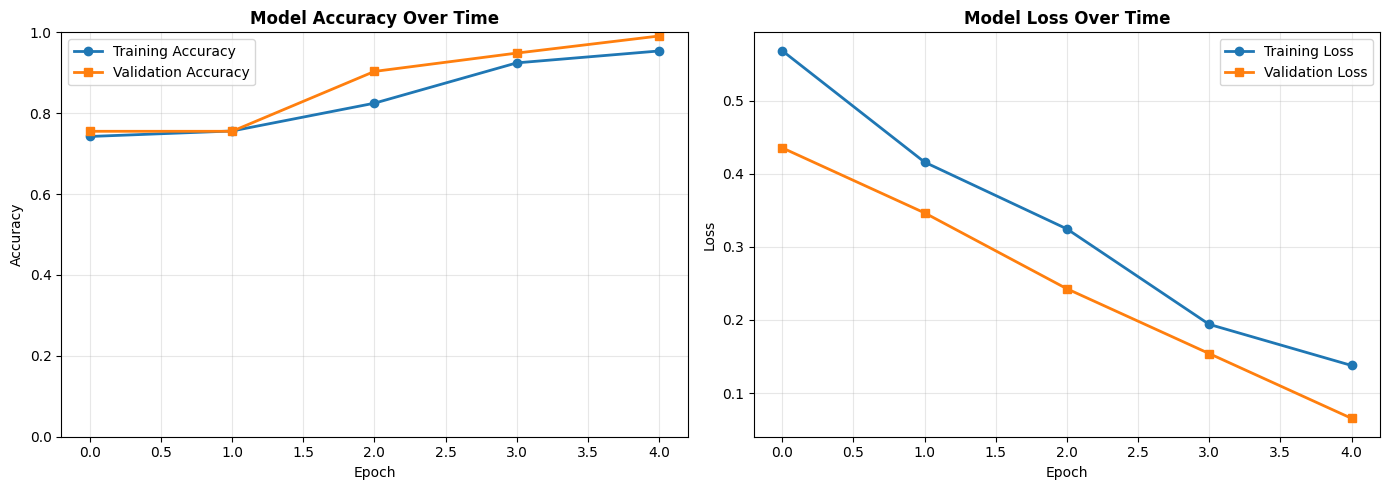

In [ ]:
def plot_training_history(history):
    """
    Plot training and validation metrics.
    
    Args:
        history: Training history object from model.fit()
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', linewidth=2)
    axes[0].set_title('Model Accuracy Over Time', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', marker='o', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
    axes[1].set_title('Model Loss Over Time', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training history
print("Training History:")
plot_training_history(history)


### Understanding the Training Curves

**What to look for:**
- **Good**: Training and validation curves are close together (no overfitting)
- **Good**: Both accuracy increasing and loss decreasing
- **Warning**: Large gap between training and validation curves (overfitting)
- **Warning**: No improvement over epochs (model may need tuning)

**Tips for Improvement:**
- If accuracy is low: Try a deeper model, more epochs, or data augmentation
- If overfitting: Add more dropout, use regularization, or get more data
- If underfitting: Increase model capacity or train longer


## Section 7: Model Evaluation

Now let's evaluate our model on the validation set (which has labels) to see how well it performs on unseen data!

### Step 7.1: Evaluate on Validation Set (with labels)


In [ ]:
from sklearn.metrics import log_loss

# Load validation data with labels (extracted from filenames)
print("Loading validation data with labels...")
val_color_paths_eval, val_labels_eval = get_image_paths_and_labels(val_color_path)
val_depth_paths_eval, _ = get_image_paths_and_labels(val_depth_path)

print(f"Validation samples for evaluation: {len(val_color_paths_eval)}")
print(f"  Real faces: {val_labels_eval.count(0)}")
print(f"  Fake faces: {val_labels_eval.count(1)}")

# Create validation dataset for evaluation
print("\nCreating validation dataset for evaluation...")
val_dataset_eval = create_dataset(val_color_paths_eval, val_depth_paths_eval, val_labels_eval)

# Get validation predictions
print("Making predictions on validation set...")
val_predictions_eval = model.predict(val_dataset_eval, verbose=1)
val_predictions_eval_flat = val_predictions_eval.flatten()

# Calculate log loss on validation set
val_logloss = log_loss(val_labels_eval, val_predictions_eval_flat)

print("\n" + "="*60)
print("VALIDATION SET RESULTS (with labels)")
print("="*60)
print(f"Validation Log Loss: {val_logloss:.4f}")
print("="*60)


Loading validation data with labels...
Validation samples for evaluation: 505
  Real faces: 591
  Fake faces: 1817

Creating validation dataset for evaluation...
Making predictions on validation set...
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step

VALIDATION SET RESULTS (with labels)
Validation Log Loss: 0.3503


### Step 7.2: Confusion Matrix

The confusion matrix shows us exactly where our model makes mistakes!


Confusion Matrix:


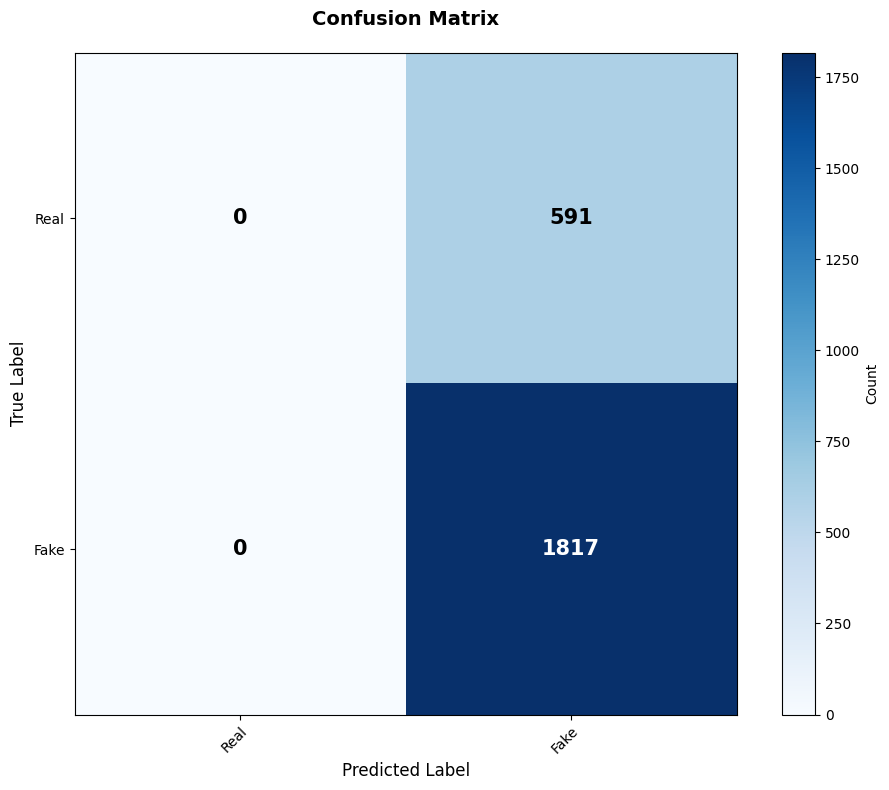


Detailed Metrics:
   Precision: 0.7546 (How many predicted fakes are actually fake?)
   Recall (Sensitivity): 1.0000 (How many fakes did we catch?)
   F1-Score: 0.8601 (Balance between precision and recall)
   Specificity: 0.0000 (How many reals did we correctly identify?)

Confusion Matrix Breakdown:
   True Positives (TP): 1817 - Correctly identified fakes
   True Negatives (TN): 0 - Correctly identified reals
   False Positives (FP): 591 - Reals misclassified as fakes
   False Negatives (FN): 0 - Fakes misclassified as reals


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_laso(y_true, y_pred, class_names):
    """
    Plot confusion matrix using matplotlib only (no seaborn).
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: Names of classes
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Title & axis labels
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Annotate matrix cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=15, fontweight='bold')
    fig.colorbar(im, ax=ax, label='Count')
    plt.tight_layout()
    plt.show()
    
    return cm

# Plot confusion matrix for validation data using matplotlib only
print("Confusion Matrix:")
cm = plot_confusion_matrix_laso(val_labels_eval, val_pred_binary, ['Real', 'Fake'])

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\nDetailed Metrics:")
print(f"   Precision: {precision:.4f} (How many predicted fakes are actually fake?)")
print(f"   Recall (Sensitivity): {recall:.4f} (How many fakes did we catch?)")
print(f"   F1-Score: {f1_score:.4f} (Balance between precision and recall)")
print(f"   Specificity: {specificity:.4f} (How many reals did we correctly identify?)")
print(f"\nConfusion Matrix Breakdown:")
print(f"   True Positives (TP): {tp} - Correctly identified fakes")
print(f"   True Negatives (TN): {tn} - Correctly identified reals")
print(f"   False Positives (FP): {fp} - Reals misclassified as fakes")
print(f"   False Negatives (FN): {fn} - Fakes misclassified as reals")


### Step 7.3: Visualize Predictions

Let's look at some actual predictions to see how our model performs!


Sample Validation Predictions:


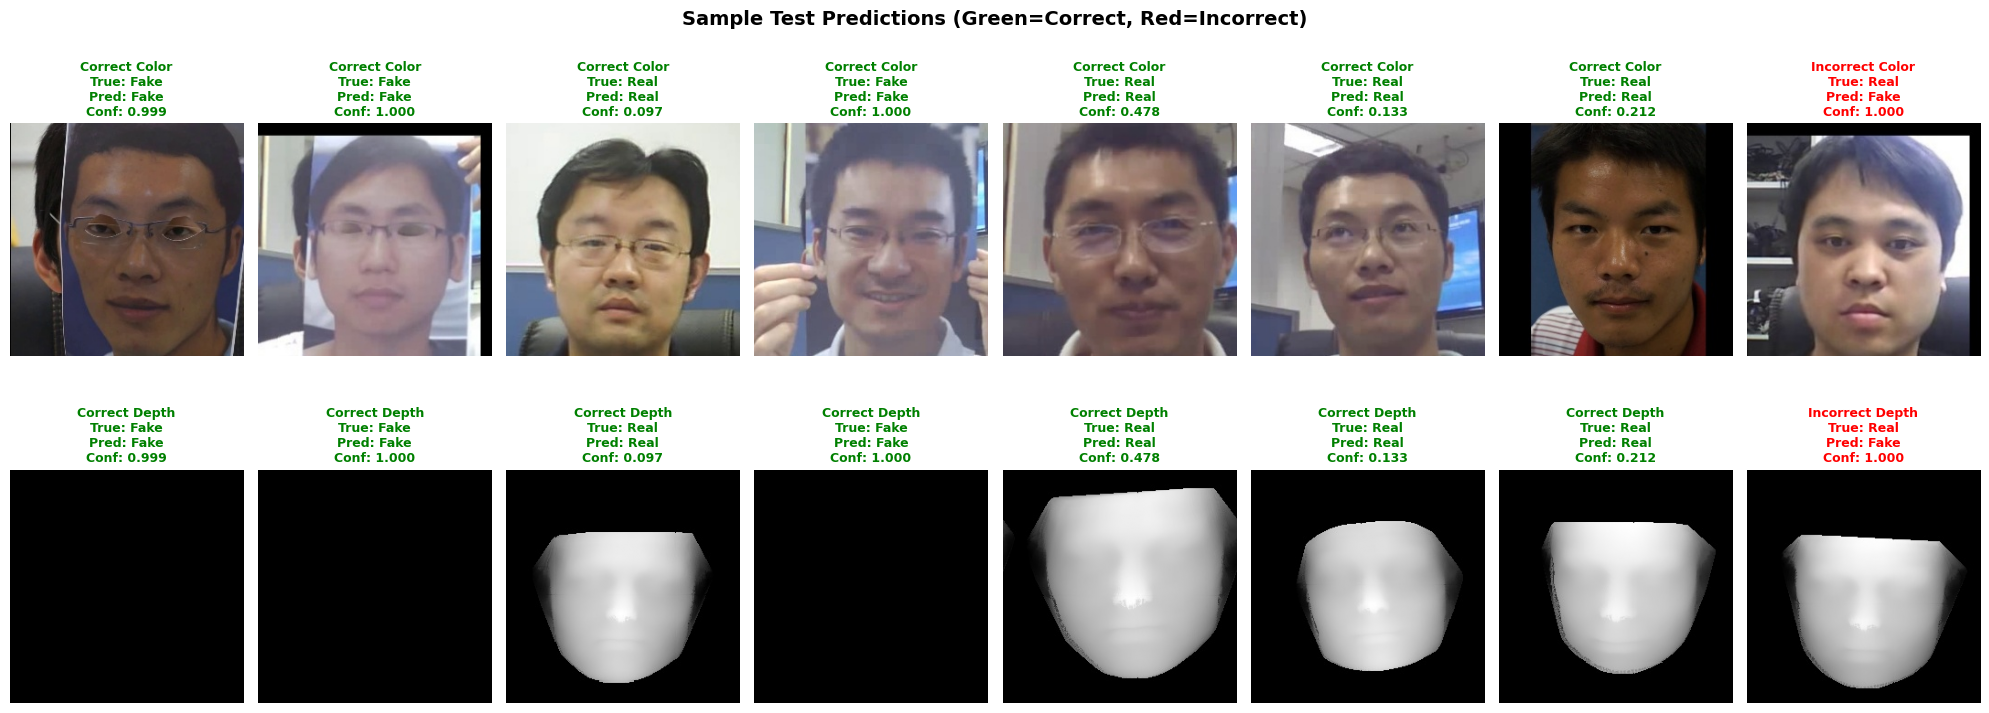

In [ ]:
def visualize_predictions(color_paths, depth_paths, labels, predictions, num_samples=8):
    """
    Visualize model predictions on test samples.
    
    Green border = Correct prediction
    Red border = Incorrect prediction
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    
    # Select random samples
    if len(color_paths) < num_samples:
        num_samples = len(color_paths)
    indices = np.random.choice(len(color_paths), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Load and display color image
        color_img = Image.open(color_paths[idx])
        axes[0, i].imshow(color_img)
        
        # Get prediction
        pred_prob = predictions[idx]
        pred_label = "Fake" if pred_prob > 0.5 else "Real"
        true_label = "Real" if labels[idx] == 0 else "Fake"
        
        # Color code: green for correct, red for incorrect
        border_color = 'green' if pred_label == true_label else 'red'
        checkmark = "Correct" if pred_label == true_label else "Incorrect"
        
        axes[0, i].set_title(f'{checkmark} Color\nTrue: {true_label}\nPred: {pred_label}\nConf: {pred_prob:.3f}', 
                           color=border_color, fontsize=9, fontweight='bold')
        axes[0, i].axis('off')
        
        # Add border to indicate correctness
        for spine in axes[0, i].spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)
        
        # Load and display depth image
        depth_img = Image.open(depth_paths[idx])
        axes[1, i].imshow(depth_img, cmap='gray')
        axes[1, i].set_title(f'{checkmark} Depth\nTrue: {true_label}\nPred: {pred_label}\nConf: {pred_prob:.3f}', 
                           color=border_color, fontsize=9, fontweight='bold')
        axes[1, i].axis('off')
        
        # Add border to indicate correctness
        for spine in axes[1, i].spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)
    
    plt.suptitle('Sample Test Predictions (Green=Correct, Red=Incorrect)', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Visualize validation predictions
print("Sample Validation Predictions:")
visualize_predictions(val_color_paths_eval, val_depth_paths_eval, val_labels_eval, val_predictions_eval.flatten())


### Step 7.4: Test Set Predictions (For Final Submission)

Now let's generate predictions on the test set for final submission. This test set is used for your final submission to the competition platform.

**Important Notes:**
- The test set has NO labels provided - you'll predict them!
- DO NOT use this test set for training your model (data leakage!)
- Generate predictions in the required submission format (probabilities: real, fake)


In [ ]:
# Load test data directly from directory (no labels provided)
print("Loading test data from test directory...")
# Convert to absolute path to avoid any path resolution issues
test_color_path_abs = os.path.abspath(test_color_path)
test_depth_path_abs = os.path.abspath(test_depth_path)
print(f"Checking path: {test_color_path_abs}")
print(f"Path exists: {os.path.exists(test_color_path_abs)}")

# Test images are named: image_01.jpg, image_02.jpg, etc.
# We'll get all images from the test directory
# NOTE: Test images may not have depth images, so we'll work with color-only if needed

test_color_paths_sub = []
test_depth_paths_sub = []  # Will be None for images without depth
test_image_ids = []
has_depth = []  # Track which images have depth

# Get all test image files
if os.path.exists(test_color_path_abs):
    files = os.listdir(test_color_path_abs)
    print(f"Found {len(files)} files in test color directory")
    if len(files) > 0:
        print(f"Sample files: {files[:5]}")
    
    for filename in sorted(files):
        if filename.endswith('.jpg'):
            # Extract image_id from filename (remove .jpg extension)
            image_id = filename.replace('.jpg', '')
            
            color_path = os.path.join(test_color_path_abs, filename)
            depth_path = os.path.join(test_depth_path_abs, filename)
            
            # Accept image if color exists (depth is optional)
            if os.path.exists(color_path):
                test_color_paths_sub.append(color_path)
                test_image_ids.append(image_id)
                
                # Check if depth exists
                if os.path.exists(depth_path):
                    test_depth_paths_sub.append(depth_path)
                    has_depth.append(True)
                else:
                    test_depth_paths_sub.append(None)  # Mark as missing depth
                    has_depth.append(False)
    
    depth_count = sum(has_depth)
    print(f"Successfully loaded {len(test_color_paths_sub)} test images")
    print(f"  Images with depth: {depth_count}")
    print(f"  Images without depth: {len(test_color_paths_sub) - depth_count}")
    if depth_count < len(test_color_paths_sub):
        print("  Note: Will create depth channel from color image for images without depth")
else:
    print(f"ERROR: Test color path does not exist: {test_color_path_abs}")
    print(f"Current working directory: {os.getcwd()}")
    print("\nTrying alternative paths...")
    # Try alternative path structures (both relative and absolute)
    alt_paths = [
        "test_img/test_img/color",
        "face_spoofing_data/test_img/color",
        "test_img/color",
        os.path.abspath("test_img/test_img/color"),
        os.path.abspath("face_spoofing_data/test_img/color"),
        os.path.abspath("test_img/color")
    ]
    found_path = False
    for alt_path in alt_paths:
        alt_path_abs = os.path.abspath(alt_path) if not os.path.isabs(alt_path) else alt_path
        if os.path.exists(alt_path_abs):
            print(f"Found alternative path: {alt_path_abs}")
            test_color_path_abs = alt_path_abs
            test_depth_path_abs = alt_path_abs.replace(os.sep + 'color', os.sep + 'depth').replace('/color', '/depth')
            found_path = True
            # Retry loading with the new path
            if os.path.exists(test_color_path_abs):
                files = os.listdir(test_color_path_abs)
                print(f"Found {len(files)} files in test color directory")
                if len(files) > 0:
                    print(f"Sample files: {files[:5]}")
                
                for filename in sorted(files):
                    if filename.endswith('.jpg'):
                        image_id = filename.replace('.jpg', '')
                        color_path = os.path.join(test_color_path_abs, filename)
                        depth_path = os.path.join(test_depth_path_abs, filename)
                        
                        # Accept image if color exists (depth is optional)
                        if os.path.exists(color_path):
                            test_color_paths_sub.append(color_path)
                            test_image_ids.append(image_id)
                            
                            # Check if depth exists
                            if os.path.exists(depth_path):
                                test_depth_paths_sub.append(depth_path)
                                has_depth.append(True)
                            else:
                                test_depth_paths_sub.append(None)  # Mark as missing depth
                                has_depth.append(False)
                
                depth_count = sum(has_depth)
                print(f"Successfully loaded {len(test_color_paths_sub)} test images")
                print(f"  Images with depth: {depth_count}")
                print(f"  Images without depth: {len(test_color_paths_sub) - depth_count}")
                if depth_count < len(test_color_paths_sub):
                    print("  Note: Will create depth channel from color image for images without depth")
            break
    
    if not found_path:
        print("Could not find test images in any alternative path!")
        print("\nPlease ensure test images are in one of these locations:")
        for alt_path in ["face_spoofing_data/test_img/test_img/color", "test_img/test_img/color", "test_img/color"]:
            print(f"  - {os.path.abspath(alt_path)}")

# Display test statistics
print("\n" + "="*50)
print("TEST SET STATISTICS")
print("="*50)
print(f"Test samples: {len(test_color_paths_sub)}")
print("="*50)
print("Note: This test set is used for final submission.")
print("   DO NOT use it for training your model!")
print("   Labels are NOT provided - you'll predict them!")

# Check if we have test images
if len(test_color_paths_sub) == 0:
    print("\nERROR: No test images found!")
    print(f"   Expected path: {test_color_path}")
    print("   Please check that test images exist in the test directory.")
    raise ValueError("No test images found. Cannot generate predictions.")

# Create a modified dataset function that handles missing depth images
def create_dataset_with_optional_depth(color_paths, depth_paths, labels, batch_size=32, target_size=(224, 224)):
    """
    Create TensorFlow dataset from image paths and labels.
    Handles missing depth images by creating depth channel from color image grayscale.
    
    Args:
        color_paths: List of color image paths
        depth_paths: List of depth image paths (can contain None for missing depth)
        labels: List of labels
        batch_size: Batch size for training
        target_size: Target image size
        
    Returns:
        Batched and prefetched TensorFlow dataset
    """
    def generator():
        for i in range(len(color_paths)):
            # Load and preprocess color image (RGB - 3 channels)
            color_img = load_and_preprocess_image(color_paths[i], target_size)
            
            # Handle depth image (create from color if missing)
            if depth_paths[i] is not None and os.path.exists(depth_paths[i]):
                # Load actual depth image
                depth_img = load_and_preprocess_image(depth_paths[i], target_size)
                depth_channel = depth_img[:, :, :1]  # Shape: (224, 224, 1)
            else:
                # Create depth channel from grayscale version of color image
                # Convert RGB to grayscale using standard weights
                gray = np.dot(color_img[...,:3], [0.2989, 0.5870, 0.1140])
                depth_channel = gray[:, :, np.newaxis]  # Shape: (224, 224, 1)
            
            # Combine color and depth: RGB + D = 4 channels
            combined_img = np.concatenate([color_img, depth_channel], axis=-1)
            yield combined_img, labels[i]
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(*target_size, 4), dtype=tf.float32),  # 4-channel input
            tf.TensorSpec(shape=(), dtype=tf.int32)  # Label
        )
    )
    
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
# Create test dataset (no labels needed for prediction)
print("\nCreating test dataset...")
# We need dummy labels for dataset creation, but we won't use them
dummy_labels = [0] * len(test_color_paths_sub)
test_dataset_sub = create_dataset_with_optional_depth(test_color_paths_sub, test_depth_paths_sub, dummy_labels)

# Get test predictions
print("Making predictions on test set...")
test_predictions_sub = model.predict(test_dataset_sub, verbose=1)
# Convert probabilities to the required format (real and fake columns)
test_pred_real_prob = 1 - test_predictions_sub.flatten()
test_pred_fake_prob = test_predictions_sub.flatten()

print("\n" + "="*60)
print("TEST PREDICTIONS GENERATED")
print("="*60)
print(f"Generated predictions for {len(test_pred_real_prob)} test images")
print(f"   Predictions: 'real' probability, 'fake' probability")
print("="*60)

# Create submission file in the correct format
print("\nCreating submission file...")
submission_df = pd.DataFrame({
    'image_id': test_image_ids,
    'real': test_pred_real_prob,
    'fake': test_pred_fake_prob
})

# Sort by image_id to ensure consistent order
submission_df = submission_df.sort_values('image_id').reset_index(drop=True)

# Save submission file
submission_filename = 'test_submission.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"\nSubmission file created: {submission_filename}")
print(f"   Format: image_id, real, fake (probabilities)")
print(f"   Total predictions: {len(submission_df)}")
print(f"\nSample of submission file:")
print(submission_df.head(10))
print("\nTip: Submit this file to the competition platform for final submission!")


Loading test data from test directory...
Checking path: c:\Users\ssikadi.AONZWARSHRE\Desktop\ZINDI\First Event\face_spoofing_data\test_img\test_img\color
Path exists: True
Found 620 files in test color directory
Sample files: ['image_01.jpg', 'image_02.jpg', 'image_03.jpg', 'image_04.jpg', 'image_05.jpg']
Successfully loaded 620 test images
  Images with depth: 0
  Images without depth: 620
  Note: Will create depth channel from color image for images without depth

TEST SET STATISTICS
Test samples: 620
Note: This test set is used for final submission.
   DO NOT use it for training your model!
   Labels are NOT provided - you'll predict them!

Creating test dataset...
Making predictions on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step

TEST PREDICTIONS GENERATED
Generated predictions for 620 test images
   Predictions: 'real' probability, 'fake' probability

Creating submission file...

Submission file created: test_submission.csv
   Format: image_id, real, fake (probabilities)


## Section 8: Save Model and Summary

Let's save our trained model and create a summary of our results!


In [55]:
# Save the trained model
model_path = 'spoofing_detection_model.h5'
model.save(model_path)
print(f"Model saved as '{model_path}'")

# Create a summary of results
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)
print(f"Dataset: Face Spoofing Detection")
print(f"   Training samples: {len(train_color_paths_split)}")
print(f"   Validation samples (for training split): {len(val_color_paths_split)}")
print(f"   Validation samples (for evaluation): {len(val_color_paths_eval)}")
print(f"   Test samples: {len(test_color_paths_sub)}")
print(f"\nModel Architecture: CNN with 4-channel input (RGB + Depth)")
print(f"   Input shape: (224, 224, 4)")
print(f"   Output: Binary classification (0=Real, 1=Fake)")
print(f"\nValidation Performance (with labels):")
print(f"   Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"   Precision: {precision:.4f}")
print(f"   Recall: {recall:.4f}")
print(f"   F1-Score: {f1_score:.4f}")
print(f"   Specificity: {specificity:.4f}")
print("\n" + "="*70)
print("Model training and evaluation completed successfully!")
print("="*70)


Model saved as 'spoofing_detection_model.h5'

FINAL RESULTS SUMMARY
Dataset: Face Spoofing Detection
   Training samples: 2017
   Validation samples (for training split): 505
   Validation samples (for evaluation): 505
   Test samples: 620

Model Architecture: CNN with 4-channel input (RGB + Depth)
   Input shape: (224, 224, 4)
   Output: Binary classification (0=Real, 1=Fake)

Validation Performance (with labels):
   Accuracy: 0.7546 (75.46%)
   Precision: 0.7546
   Recall: 1.0000
   F1-Score: 0.8601
   Specificity: 0.0000

Model training and evaluation completed successfully!


## Thank You for Participating!

- A huge thank you to all participants who joined us for this exciting hackathon representing **Zindi + IndabaX Zimbabwe Hackathon: Building Africa's Next Generation of AI Innovators**!

- Your dedication, creativity, and hard work in developing AI solutions for face spoofing detection made this event truly special. We hope you enjoyed the challenges and learned valuable skills in applying deep learning techniques to real-world security problems.

- For any inquiries, questions, or feedback, please don't hesitate to reach out:  

 **Shannon Tafadzwa Sikadi**  

 *Zindi Community Ambassador*  

Email: shannonsikadi@gmail.com

GitHub: https://github.com/ShannonT20

Keep innovating and pushing boundaries!

Until next time!
